In [1]:
import pennylane as qml
import pennylane.templates as qmlt
import torch

In [2]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

In [3]:
@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def circuit(inputs, weights):
    qmlt.AngleEmbedding(inputs, wires=range(n_qubits))
    qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [4]:
inputs = torch.randn(n_qubits)
weights = torch.randn(n_qubits, n_qubits)

In [5]:
print(inputs)
print(weights)

tensor([ 0.9204, -0.3530,  0.4478])
tensor([[ 0.6794, -0.4662,  0.0744],
        [-0.4530,  0.0783,  0.3620],
        [ 1.4607,  0.6202, -0.3046]])


0: ──RX(0.92)───RX(0.68)──╭●────╭X──RX(-0.45)─╭●────╭X──RX(1.46)──╭●────╭X─┤  <Z>
1: ──RX(-0.35)──RX(-0.47)─╰X─╭●─│───RX(0.08)──╰X─╭●─│───RX(0.62)──╰X─╭●─│──┤  <Z>
2: ──RX(0.45)───RX(0.07)─────╰X─╰●──RX(0.36)─────╰X─╰●──RX(-0.30)────╰X─╰●─┤  <Z>


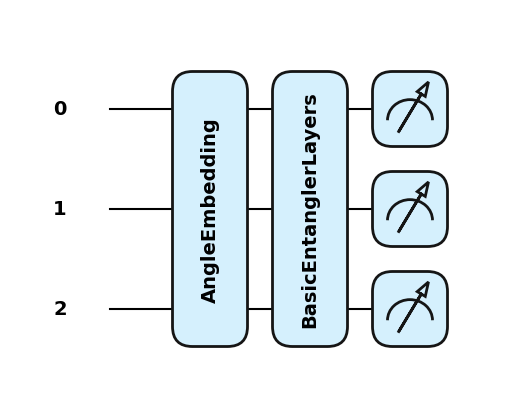

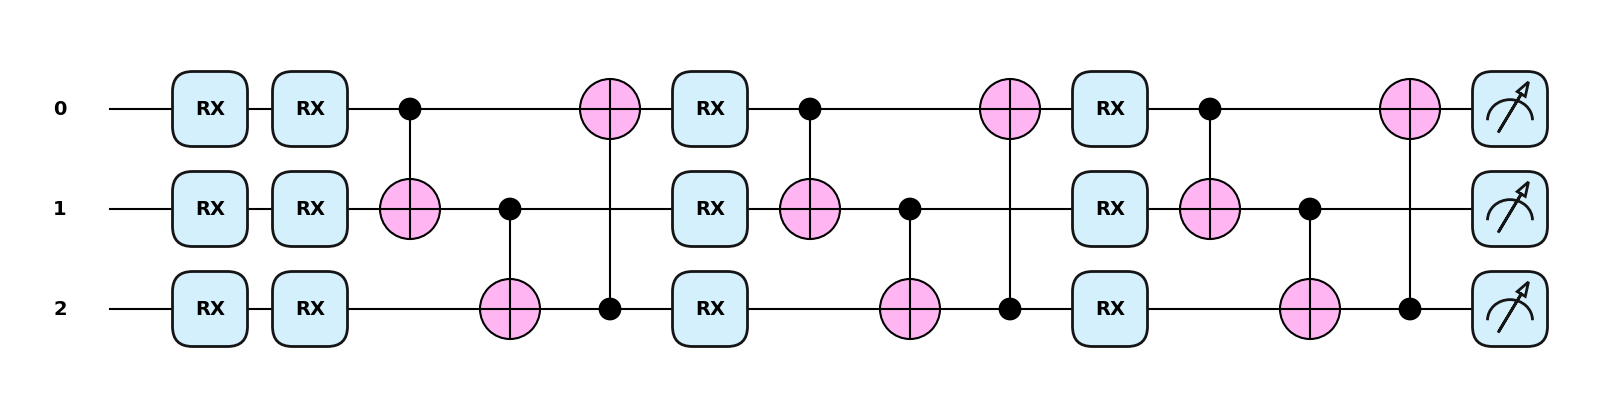

In [6]:
qml.drawer.use_style("pennylane")
print(qml.draw(circuit, expansion_strategy="device")(inputs, weights))
fig1, ax = qml.draw_mpl(circuit)(inputs, weights)
fig2, ax = qml.draw_mpl(circuit, expansion_strategy="device")(inputs, weights)

In [7]:
import torch.nn.functional as F

# Optionally use the context manager to ensure one of the fused kernels is run
query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
with torch.backends.cuda.sdp_kernel(enable_math=False):
    F.scaled_dot_product_attention(query, key, value)

AssertionError: Torch not compiled with CUDA enabled